In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
# import torch
# import torch.distributions.categorical
import scipy
import scipy.stats
import math


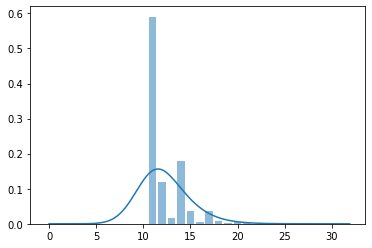

In [9]:
dist = pd.read_csv('distr.csv')
#dist.head(10)
rx = dist['r'].to_numpy()
rp = dist['p'].to_numpy()
n = np.max(np.where(rp > 1e-6))
rx = rx[0:n]
rp = rp[0:n]

distr = scipy.stats.rv_discrete(values=(rx, rp))
# h = plt.bar(rx, rp, alpha=0.5)
h = plt.bar(rx, distr.pmf(rx), alpha=0.5)
kernel = scipy.stats.gaussian_kde(rx, weights=rp)
range = np.arange(0, n, 0.1)
plt.plot(range, kernel(range))
# plt.fill_between(range, kernel(range))

In [4]:
arr = np.array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.531, 0.159, 0.032, 0.165, 0.049, 0.010, 0.033, 0.010, 0.002, 0.006, 0.002, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000])

(0.0, 0.6)

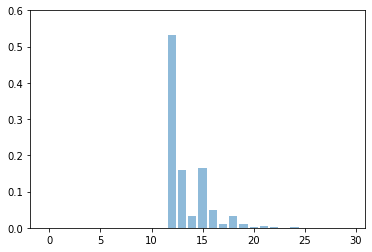

In [6]:
plt.bar(np.arange(30),arr[:30], alpha=0.5)
weights = np.ones(51)*1/50
plt.ylim([0, 0.6])

In [10]:
arr2 = np.array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.531, 0.159, 0.032, 0.165, 0.049, 0.010, 0.033, 0.010, 0.002, 0.006, 0.002, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000 ])

(0.0, 0.6)

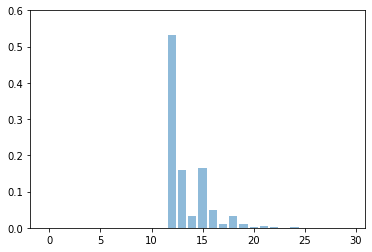

In [11]:
plt.bar(np.arange(30),arr2[:30], alpha=0.5)
weights = np.ones(51)*1/50
plt.ylim([0, 0.6])

In [5]:
arr_qr = np.array([12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 12.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 13.000, 14.000, 14.000, 14.000, 14.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 15.000, 16.000, 16.000, 16.000, 16.000, 16.000, 17.000, 18.000, 18.000, 18.000, 18.000, 19.000])

In [7]:
atoms = 100
delta_p = 1.0/atoms
arr_conv = np.zeros(51)

for i in range(atoms):
    val = arr_qr[i]
    low = math.floor(val)
    upp = math.ceil(val)
    if low - upp != 0:
        arr_conv[low] += (val - low) * delta_p
        arr_conv[upp] += (upp - val) * delta_p
    else:
        arr_conv[low] += delta_p
    
arr_conv

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.53, 0.16, 0.04, 0.16, 0.05, 0.01, 0.04, 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

(0.0, 0.6)

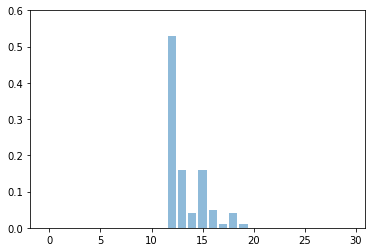

In [8]:
plt.bar(np.arange(0,30),arr_conv[:30], alpha=0.5)
plt.ylim([0, 0.6])

In [14]:
arr3 = np.array([0.000, 0.000, 0.000, 0.010, 0.061, 0.165, 0.251, 0.239, 0.153, 0.074, 0.030, 0.011, 0.004, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000 ])

In [20]:
vmax = 100
atoms=51

In [29]:
np.arange(0,60,2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58])

(0.0, 0.6)

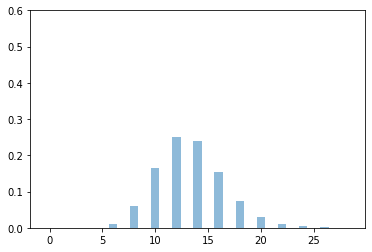

In [31]:
plt.bar(np.arange(0,32,2),arr3[:15], alpha=0.5)
plt.ylim([0, 0.6])